# TPC-H Multi-Tenant in PostgreSQL with PVC

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np
from scipy.stats import gmean

from dbmsbenchmarker import parameter, inspector

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
#path = r"C:\data\benchmarks"
path = r"/home/perdelt/benchmarks"
filename_prefix = ''

In [9]:
def get_workload(code):
    """
    Maps a query index string (e.g., 'q1', 'q2', etc.) to a human-readable query title 
    from the global ``query_properties`` dictionary.

    If the title is not found in ``query_properties``, the input string is returned as-is.

    :param numQuery: A string representing the query index, typically starting with a letter 
                     followed by a number (e.g., ``'q1'``, ``'q2'``).
    :type numQuery: str
    :return: The title of the query if available in ``query_properties``, otherwise the original input string.
    :rtype: str
    """
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def map_index_to_queryname(numQuery):
    """
    Maps a query index string (e.g., 'q1', 'q2', etc.) to a human-readable query title 
    from the global `query_properties` dictionary.

    If the title is not found in `query_properties`, the input string is returned as-is.

    Parameters
    ----------
    numQuery : str
        A string representing the query index, typically starting with a letter followed by a number (e.g., 'q1').

    Returns
    -------
    str
        The title of the query if available in `query_properties`, otherwise the original input string.
    """
    global query_properties
    if numQuery[1:] in query_properties and 'config' in query_properties[numQuery[1:]] and 'title' in query_properties[numQuery[1:]]['config']:
        return query_properties[numQuery[1:]]['config']['title']
    else:
        return numQuery


def get_performance_single(evaluate):
    """
    Reads the performance metrics and returns them without any aggregation across clients.
    Computes performance metrics for a single experiment run, including latency, execution power,
    throughput, and timing details for each connection/client.

    This function uses benchmarking results from a given evaluator instance, maps query indices
    to human-readable names, and calculates a set of performance indicators such as:
    - Power@Size: estimated performance at a given scale factor
    - Geo Times: geometric mean of execution runtimes
    - Throughput@Size: estimated throughput per hour at a given scale factor, is number of queries executed per hour scaled by SF and number of clients

    :param evaluate: An evaluator object containing benchmarking and experiment data.
    :type evaluate: object
    :return: A DataFrame containing various aggregated performance metrics including runtime, throughput,
             number of queries, and associated configuration like client count and SF.
    :rtype: pandas.DataFrame
    """
    global query_properties
    query_properties = evaluate.get_experiment_query_properties()
    num_of_queries = 0
    df = evaluate.get_aggregated_query_statistics(type='latency', name='execution', query_aggregate='Mean')
    if not df is None:
        df = df.sort_index().T.round(2)
        df.index = df.index.map(map_index_to_queryname)
        num_of_queries = len(df.index)
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index().astype('float')
    df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
    df_power = df.copy()
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index()
    df.columns = ['Geo Times [s]']
    df_geo_mean_runtime = df.copy()
    df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
    df_merged_time = pd.DataFrame()
    for connection_nr, connection in evaluate.benchmarks.dbms.items():
        df_time = pd.DataFrame()
        c = connection.connectiondata
        connection_name = c['name']
        orig_name = c['orig_name']
        eva = evaluate.get_experiment_connection_properties(c['name'])
        df_time.index = [connection_name]
        df_time['orig_name'] = orig_name
        df_time['connection_name'] = connection_name
        df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_merged_time = pd.concat([df_merged_time, df_time])
    df_time = df_merged_time.sort_index()
    # aggregate per parallel pods per dbms - not valid for model=container?
    #benchmark_start = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    #benchmark_end = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    benchmark_start = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    benchmark_end = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])
    df_benchmark.columns = ['time [s]']
    benchmark_count = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).count()
    df_benchmark['count'] = benchmark_count['benchmark_end']
    df_benchmark['SF2'] = df_benchmark.index.map(lambda x: x[1])
    df_benchmark['num_of_queries'] = num_of_queries
    df_benchmark['Throughput@Size'] = (num_of_queries*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF2']).round(2)
    index_names = list(df_benchmark.index.names)
    index_names[0] = "DBMS"
    df_benchmark.rename_axis(index_names, inplace=True)
    df_benchmark = df_benchmark.reset_index(level=['SF', 'num_experiment', 'num_client'])
    df = pd.concat([df, df_benchmark], axis=1)
    df.drop('SF2', axis=1, inplace=True)
    df.rename(columns={'num_experiment': 'experiment_run'}, inplace=True)
    df.rename(columns={'num_client': 'client'}, inplace=True)
    df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
    df = df.sort_values(['experiment_run', 'client'])
    return df


def get_performance(evaluation):
    df = get_performance_single(evaluation)
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Throughput@Size': 'sum',
        'time [s]': 'max',
        'num_of_queries': 'max',
        'SF': 'max',
        'count': 'sum',
        'Power@Size [~Q/h]': lambda x: gmean(x.dropna()), # 'prod',
        #'num_errors': 'sum',
        #'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    result['Throughput@Size'] = (result['num_of_queries']*3600.*result['count']/result['time [s]']*result['SF']).round(2)
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        #print(code)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.base(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                #'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring(evaluation, type="stream"):
    df_monitoring = show_summary_monitoring_table(evaluation, type)
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_monitoring_all(codes, type):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring(evaluation, type)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [10]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    """
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    """
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpch_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



In [11]:
def plot_boxplots(df, y, title):
    plt.figure(figsize=(10, 6))
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    
    # Plot boxplots grouped by num_tenants and colored by type
    ax = sns.boxplot(
        data=df,
        x='num_tenants',
        y=y,#'Goodput (requests/second)',
        hue='type',
        palette='Set2'  # consistent colors per type
    )
    # Add vertical separator lines between groups
    # Get the number of unique num_tenants and type
    num_groups = df['num_tenants'].nunique()
    num_types = df['type'].nunique()
    
    # Extract hue order
    hue_order = ax.get_legend_handles_labels()[1]
    num_hue = len(hue_order)
    
    # Get hue order from seaborn (types)
    _, type_order = ax.get_legend_handles_labels()
    num_types = len(type_order)
    
    #print(len(ax.patches))
    # Set hatches correctly: patches are grouped by x then by hue
    for i, patch in enumerate(ax.patches):
        #print(i)
        type_index = i // (num_groups)
        if type_index >= num_types:
            break
        type_name = type_order[type_index]
        patch.set_hatch(hatch_map.get(type_name, ''))
        #print(hatch_map.get(type_name, ''))
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    
    # Each num_tenants group has num_types boxes
    for i in range(1, num_groups):
        xpos = i - 0.5 #0.5
        ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)
    
    
    # Update legend with matching hatches
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
    
    #title = "Goodput [req/s] Distribution per Tenant"
    plt.title(title, fontsize=24)
    plt.xlabel("Number of Tenants")
    plt.ylabel("")#"Goodput (requests/second)")
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    plt.legend(title="Type")
    ax.legend(fontsize=18)
    plt.tight_layout()
    filename = "tpch_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Container

In [12]:
codes = ['1751049830', '1751042932', '1751036351', '1751030495', '1751024409', '1751018248', '1751119375', '1751111813', '1751104451', '1751126280', '1751134502', '1751142830',
         '1751150564', '1751178052', '1751186509',
         '1751194758', # schema 6
         '1751204267', # db 6
         '1751223797', # container 6
         '1751270408',
         '1751281756',
         #'1751270408', # schema 7
         #'1751281756', # db 7
         #'1751294606', # container 7
         '1751303210', # schema 8
         '1751315193', # db 8
         #'1751327437', # container 8
         '1751337551', # schema 9
         #'1751351420', # db 9 OOM
         '1751437705', # db 9
         '1751359843', # schema 10
         '1751468423', # db 10
        ]

codes

['1751049830',
 '1751042932',
 '1751036351',
 '1751030495',
 '1751024409',
 '1751018248',
 '1751119375',
 '1751111813',
 '1751104451',
 '1751126280',
 '1751134502',
 '1751142830',
 '1751150564',
 '1751178052',
 '1751186509',
 '1751194758',
 '1751204267',
 '1751223797',
 '1751270408',
 '1751281756',
 '1751303210',
 '1751315193',
 '1751337551',
 '1751437705',
 '1751359843',
 '1751468423']

## Per Tenant

In [13]:
df_performance = get_performance_all_single(codes)
df_performance

,total_timer_execution,Power@Size [~Q/h],Geo Times [s],SF,experiment_run,client,time [s],count,num_of_queries,Throughput@Size,type,num_tenants
DBMS,,,,,,,,,,,,
PostgreSQL-BHT-1-0-1-1,5.581958,6449.350079,5.581958,10.0,1,1,1931,1,22,410.15,container,2
PostgreSQL-BHT-1-1-1-1,5.725308,6287.871693,5.725308,10.0,1,1,1961,1,22,403.88,container,2
PostgreSQL-BHT-1-0-2-1,5.600174,6428.371549,5.600174,10.0,1,2,1928,1,22,410.79,container,2
PostgreSQL-BHT-1-1-2-1,5.662387,6357.742695,5.662387,10.0,1,2,1935,1,22,409.30,container,2
PostgreSQL-BHT-2-1-1,5.805220,6201.315561,5.805220,10.0,1,1,1980,1,22,400.00,database,2
PostgreSQL-BHT-2-1-2,5.859996,6143.349100,5.859996,10.0,1,1,1995,1,22,396.99,database,2
PostgreSQL-BHT-2-2-1,5.786509,6221.367407,5.786509,10.0,1,2,1967,1,22,402.64,database,2
PostgreSQL-BHT-2-2-2,5.816515,6189.273202,5.816515,10.0,1,2,1983,1,22,399.39,database,2
PostgreSQL-BHT-2-1-1,5.804136,6202.473081,5.804136,10.0,1,1,1999,1,22,396.20,schema,2


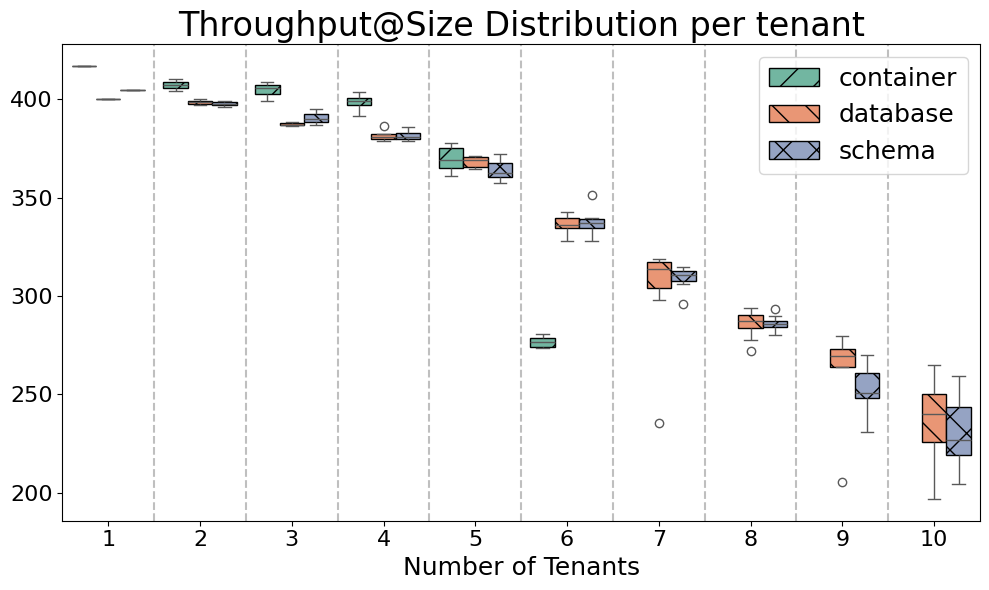

In [14]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
plot_boxplots(df, y='Throughput@Size', title='Throughput@Size Distribution per tenant')

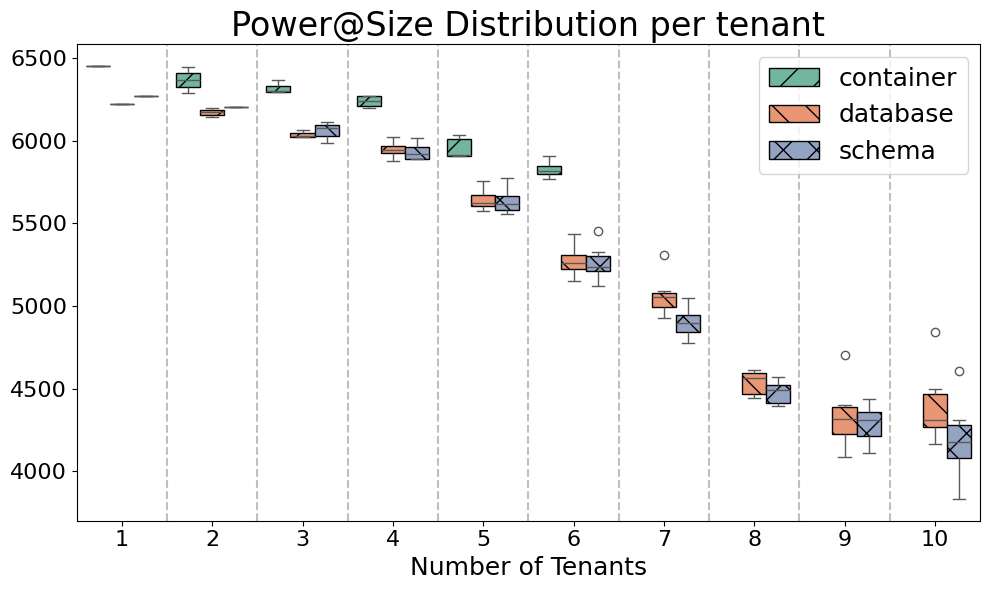

In [15]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
plot_boxplots(df, y='Power@Size [~Q/h]', title='Power@Size Distribution per tenant')

## Per Total

In [16]:
df_performance = get_performance_all(codes)
df_performance

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants
0,1,807.75,1961,22,10.0,2,6368.099072,container,2
1,2,818.60,1935,22,10.0,2,6392.959585,container,2
0,1,793.98,1995,22,10.0,2,6172.264282,database,2
1,2,798.79,1983,22,10.0,2,6205.299555,database,2
0,1,792.40,1999,22,10.0,2,6204.870707,schema,2
1,2,793.19,1997,22,10.0,2,6193.703735,schema,2
0,1,416.84,1900,22,10.0,1,6453.282885,container,1
1,2,412.29,1921,22,10.0,1,6399.072262,container,1
0,1,400.00,1980,22,10.0,1,6226.076538,database,1
1,2,402.64,1967,22,10.0,1,6270.759668,database,1


In [ ]:
plot_bars(df_performance, y='Throughput@Size', title='Throughput@Size', estimator='min')

In [ ]:
plot_bars(df_performance, y='Power@Size [~Q/h]', title='Power@Size', estimator='min')

In [ ]:
df_performance = get_loading_time_max_all(codes)
df_performance

In [ ]:
df_performance_first = df_performance[df_performance['client'] == '1']
# Divide datadisk by the count of rows with the same type and num_tenants
df = df_performance_first.copy()
# Create a mask for rows where type is not "container"
mask = df['type'] != 'container'

# Only apply the group count to the relevant rows
group_counts = df[mask].groupby(['type', 'num_tenants'])['datadisk'].transform('count')

# Initialize the column with NaN (or 0, if preferred)
df['datadisk_normalized'] = df['datadisk'] / 1024

# Apply the normalized value only where the mask is True
df.loc[mask, 'datadisk_normalized'] = df.loc[mask, 'datadisk'] / group_counts / 1024

plot_bars(df, y='datadisk_normalized', title='Database Size [GB]', estimator='sum')

In [ ]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

In [ ]:
plot_bars(df_performance, y='time_check', title='Time for Indexing [s]', estimator='max')

## Hardware Benchmarking

In [ ]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance = df_performance.sort_values(['num_tenants', 'type'])
df_performance

In [ ]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

In [ ]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

In [ ]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

In [ ]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

## Hardware Loading

In [ ]:
df_performance = get_monitoring_all(codes, type="loading")
df_performance = df_performance[df_performance['client'] == '1']
df_performance = df_performance.sort_values(['num_tenants', 'type'])
df_performance

In [ ]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

In [ ]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

# Efficiency

In [ ]:
client = 1

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance["client"] = df_performance["client"].astype(int)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / (merged_df['Throughput@Size'])
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / (merged_df['Throughput@Size'] / 3600.)
#merged_df['E_RAM'] = (merged_df['Throughput@Size']) / merged_df['Max RAM [Gb]']
#merged_df['E_CPU'] = (merged_df['Throughput@Size'] * 3600.) / merged_df['CPU [CPUs]']
merged_df['E_CPU'] = (10. * merged_df['num_tenants'] * merged_df['num_of_queries'] * merged_df['SF']) / merged_df['CPU [CPUs]']
merged_df['E_RAM'] = (10. * merged_df['num_tenants'] * merged_df['num_of_queries'] * merged_df['SF']) / merged_df['Max RAM [Gb]']

merged_df

In [ ]:
plot_bars(merged_df, y='E_CPU', title='1st run - $E_{CPU}$', estimator='max')

In [ ]:
plot_bars(merged_df, y='E_RAM', title='1st run - $E_{RAM}$', estimator='max')

In [ ]:
client = 2

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance["client"] = df_performance["client"].astype(int)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / (merged_df['Throughput@Size'])
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / (merged_df['Throughput@Size'] / 3600.)
#merged_df['E_RAM'] = (merged_df['Throughput@Size']) / merged_df['Max RAM [Gb]']
#merged_df['E_CPU'] = (merged_df['Throughput@Size'] * 3600.) / merged_df['CPU [CPUs]']
merged_df['E_CPU'] = (10. * merged_df['num_tenants'] * merged_df['num_of_queries'] * merged_df['SF']) / merged_df['CPU [CPUs]']
merged_df['E_RAM'] = (10. * merged_df['num_tenants'] * merged_df['num_of_queries'] * merged_df['SF']) / merged_df['Max RAM [Gb]']

merged_df

In [ ]:
plot_bars(merged_df, y='E_CPU', title='2nd run - $E_{CPU}$', estimator='max')

In [ ]:
plot_bars(merged_df, y='E_RAM', title='2nd run - $E_{RAM}$', estimator='max')

In [ ]:
import os
import zipfile

def zip_all_results():
    # Set the base directory containing the folders
    base_dir = path # "/path/to/your/folders"  # CHANGE THIS to your actual directory
    # List all folder names in the directory
    folder_names = codes
    # Create a zip for each folder
    for folder in folder_names:
        folder_path = os.path.join(base_dir, folder)
        zip_path = os.path.join(base_dir, f"{folder}.zip")
        print(f"Zipping {folder_path} to {zip_path}...")
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    abs_path = os.path.join(root, file)
                    rel_path = os.path.relpath(abs_path, folder_path)
                    zipf.write(abs_path, arcname=os.path.join(folder, rel_path))
    print("✅ Done zipping all folders.")


In [ ]:
zip_all_results()